In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from numpy import unique, where
import matplotlib.pyplot as plt

import os
os.chdir('../../')

from modules import preproc
from modules.join_data import join_y
from modules import feature_eng
from modules import cluster_intelligence
from modules.evaluate_model import get_eval_scores
from modules.dbscan_grid_search import run_dbscan_gs, get_best_models
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows',150)
pd.set_option('display.max_columns',1000)

## Reading in data and preproc

In [2]:
# laptops
laptops = pd.read_json('full_data/laptops.json')
laptops = join_y(laptops, 'raw_data/laptops_sales.csv')
laptops = preproc.clean_cols(laptops)
laptops = preproc.fill_empty_lists(laptops)
laptops = preproc.preprocess_reviews(laptops)
laptops = feature_eng.generate_features(laptops)
laptops = feature_eng.do_PCA(laptops)
laptops['TOTAL_SALES_QBINNED'] = pd.qcut(laptops['TOTAL_SALES'], 3, labels=[0,1,2])

# phones
phones = pd.read_json('full_data/smartphones.json')
phones = join_y(phones, 'raw_data/phone_sales.csv')
phones = preproc.clean_cols(phones)
phones = preproc.fill_empty_lists(phones)
phones = preproc.preprocess_reviews(phones)
phones = feature_eng.generate_features(phones)
phones = feature_eng.do_PCA(phones)
phones['TOTAL_SALES_QBINNED'] = pd.qcut(phones['TOTAL_SALES'], 3, labels=[0,1,2])
# desktops
desktops = pd.read_json('full_data/desktops.json')
desktops = join_y(desktops, 'raw_data/desktops_sales.csv')
desktops = preproc.clean_cols(desktops)
desktops = preproc.fill_empty_lists(desktops)
desktops = preproc.preprocess_reviews(desktops)
desktops = feature_eng.generate_features(desktops)
desktops = feature_eng.do_PCA(desktops)
desktops['TOTAL_SALES_QBINNED'] = pd.qcut(desktops['TOTAL_SALES'], 3, labels=[0,1,2])
# tablets
tablets = pd.read_json('full_data/tablets.json')
tablets = join_y(tablets, 'raw_data/tablet_sales.csv')
tablets = tablets[tablets['no_reviews'].notna()]
tablets = preproc.clean_cols(tablets)
tablets = preproc.fill_empty_lists(tablets)
tablets = preproc.preprocess_reviews(tablets)
tablets = feature_eng.generate_features(tablets)
tablets = feature_eng.do_PCA(tablets)
tablets['TOTAL_SALES_QBINNED'] = pd.qcut(tablets['TOTAL_SALES'], 3, labels=[0,1,2])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]    

## Scaling

In [3]:
laptops = laptops.select_dtypes(include=['float', 'int64','int32','float64'])
laptops['price/Rvol'] = laptops['price/Rvol'].replace(np.inf, laptops['price/Rvol'].median())
for col in laptops.columns:
    laptops[col] = laptops[col].replace(np.nan, laptops[col].median())
laptops = (laptops-laptops.mean())/laptops.std()

laptops = feature_eng.get_y_true(laptops)



In [4]:
phones = phones.select_dtypes(include=['float', 'int64','int32','float64'])
phones['price/Rvol'] = phones['price/Rvol'].replace(np.inf, phones['price/Rvol'].median())
for col in phones.columns:
    phones[col] = phones[col].replace(np.nan, phones[col].median())
phones = (phones-phones.mean())/phones.std()

phones = feature_eng.get_y_true(phones)


In [5]:
tablets = tablets.select_dtypes(include=['float', 'int64','int32','float64'])
tablets['price/Rvol'] = tablets['price/Rvol'].replace(np.inf, tablets['price/Rvol'].median())
for col in tablets.columns:
    tablets[col] = tablets[col].replace(np.nan, tablets[col].median())
tablets = (tablets-tablets.mean())/tablets.std()

tablets = feature_eng.get_y_true(tablets)


In [6]:
desktops = desktops.select_dtypes(include=['float', 'int64','int32','float64'])
desktops['price/Rvol'] = desktops['price/Rvol'].replace(np.inf, desktops['price/Rvol'].median())
for col in desktops.columns:
    desktops[col] = desktops[col].replace(np.nan, desktops[col].median())
desktops = (desktops-desktops.mean())/desktops.std()

desktops = feature_eng.get_y_true(desktops)


In [7]:
laptops.name = 'laptops'
desktops.name = 'desktops'
phones.name = 'phones'
tablets.name = 'tablets'

## 'no_reviews','Rvol/%rec','pos_reviews'

In [8]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews','Rvol/%rec','pos_reviews'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,f1_score


## no_reviews , Rvol/%rec

In [9]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews','Rvol/%rec'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,f1_score


In [10]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,f1_score


In [11]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['Rvol/%rec'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,f1_score


In [12]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews','Rvol/%rec','pos_reviews','neg_reviews'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,f1_score


In [13]:
# This is PCA over 12 odd features (from module)
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['c1','c2'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,f1_score


In [14]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews','Rvol/%rec','price'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,f1_score


In [15]:
def evaluate_clusters(
    predicted_y,
    real_y,
):
    """Evaluates clustering results, uses silouette and rand if specified. Cannot be used with DBSCAN"""
    sns.kdeplot(predicted_y, real_y.astype(int), shade=True,shade_lowest=True,cbar=True)
    plt.title('Cluster labels with total sales')

## laptops

In [16]:
dbscan_model = DBSCAN(eps=0.6, min_samples=(len(laptops))/6)
db_clust = dbscan_model.fit_predict(laptops[['no_reviews']])
laptops['db_clust'] = pd.Series(db_clust, index=laptops.index)
get_eval_scores(laptops['y_true'], laptops['db_clust'])
#cluster_intelligence.evaluate_clusters(laptops['db_clust'] ,laptops['TOTAL_SALES'])

(1.0,
 0.875,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [17]:
dbscan_model = DBSCAN(eps=0.95, min_samples=(len(laptops))/5)
db_clust = dbscan_model.fit_predict(laptops[['no_reviews','Rvol/%rec']])
laptops['db_clust'] = pd.Series(db_clust, index=laptops.index)
get_eval_scores(laptops['y_true'], laptops['db_clust'])

(1.0,
 0.875,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [18]:
cluster_intelligence.cluster_report(laptops[['no_reviews']],db_clust)

,class_name,instance_count,rule_list
1,-1,7,NaN
0,0,105,[0.9375] ALL


In [19]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
def get_eval_scores(
    y_true,
    y_pred,
    print_results = False,
):
    """Calculates precision and recall scores of input y-vals"""
    pscore = precision_score(y_true, y_pred, pos_label=-1)
    rscore = recall_score(y_true, y_pred, pos_label=-1)
    f1score = f1_score(y_true, y_pred, pos_label=-1)
    if print_results:
        print(f"The precision score is: {pscore} and the recall is {rscore} and the f1score is {f1score}")

    return pscore, rscore, f1score

In [20]:
print(laptops.loc[laptops.db_clust==-1]['TOTAL_SALES'].mean())
print(laptops.loc[laptops.db_clust==-0]['TOTAL_SALES'].mean())

2.692044580497955
-0.17946963869986365


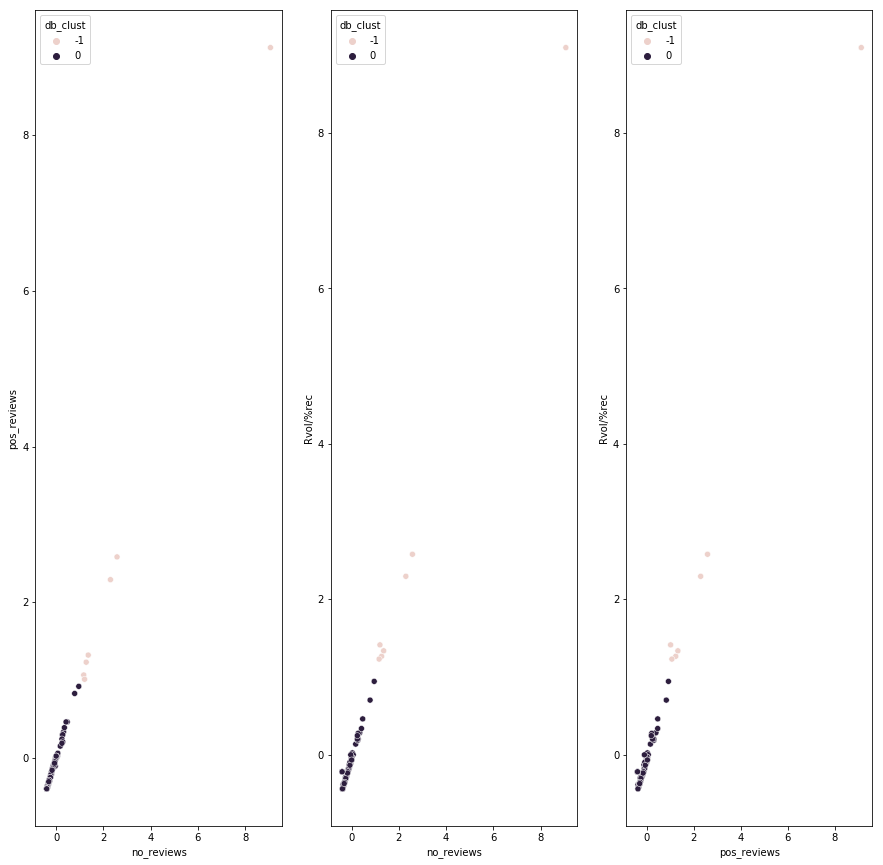

In [21]:
laptops['db_clust'] = pd.Series(db_clust, index=laptops.index)
f, axes = plt.subplots(1,3, figsize=(15,15))
sns.scatterplot(x=laptops['no_reviews'], y=laptops['pos_reviews'], hue=laptops['db_clust'],ax=axes[0])
sns.scatterplot(x=laptops['no_reviews'], y=laptops['Rvol/%rec'],hue=laptops['db_clust'], ax=axes[1])
sns.scatterplot(x=laptops['pos_reviews'], y=laptops['Rvol/%rec'],hue=laptops['db_clust'], ax=axes[2])

## phones

In [22]:

dbscan_model = DBSCAN(eps=0.6, min_samples=(len(phones))/6)
db_clust = dbscan_model.fit_predict(phones[['no_reviews']])
phones['db_clust'] = pd.Series(db_clust, index=phones.index)
get_eval_scores(phones['y_true'], phones['db_clust'])
#evaluate_clusters(phones['db_clust'] ,phones['TOTAL_SALES'])

(0.2619047619047619, 0.6111111111111112, 0.36666666666666675)

In [23]:
dbscan_model = DBSCAN(eps=0.95, min_samples=(len(phones))/5)
db_clust = dbscan_model.fit_predict(phones[['no_reviews','Rvol/%rec']])
phones['db_clust'] = pd.Series(db_clust, index=phones.index)
get_eval_scores(phones['y_true'], phones['db_clust'])

(0.2619047619047619, 0.6111111111111112, 0.36666666666666675)

In [24]:
print(phones.loc[phones.db_clust==-1]['TOTAL_SALES'].mean())
print(phones.loc[phones.db_clust==-0]['TOTAL_SALES'].mean())

0.8610308822060502
-0.1697807373364042


In [25]:
phones.loc[phones['y_true']==-1]

,index,price,remotekey,shelf_order,no_reviews,recommendation_percent,summary_star_rating,TOTAL_SALES,neg_reviews,pos_reviews,price/Rvol,Rvol/%rec,posR/Rvol,negR/Rvol,index,c1,c2,y_true,db_clust
0,-1.721886,-1.119432,-0.236987,-1.598110,2.668618,0.671424,0.639561,6.018125,0.667909,2.871703,-0.357477,2.459782,0.140270,-0.064414,-1.721886,2.079133,-0.003404,-1.0,-1
2,-1.694769,-1.250100,-0.189430,-1.484358,2.977382,0.157481,0.262152,2.832765,7.401053,2.171390,-0.358157,3.790766,-3.211646,3.219358,-1.694769,4.191226,2.708138,-1.0,-1
4,-1.667653,-0.546520,0.109254,-1.370605,1.422265,0.484535,0.592385,1.102339,0.667909,1.445916,-0.352281,1.432704,-0.443502,0.280555,-1.667653,1.276268,0.034421,-1.0,-1
5,-1.654095,-1.250100,-2.429240,-1.313729,3.421701,0.461174,0.450856,7.397433,4.192642,3.156861,-0.358220,3.592092,-1.353444,1.382670,-1.654095,3.545233,1.347360,-1.0,-1
6,-1.640537,-1.333794,-1.291538,-1.256853,2.830531,0.507896,0.498032,5.865769,2.204332,2.670415,-0.358515,2.878351,-1.128468,0.701920,-1.640537,2.623773,0.804359,-1.0,-1
7,-1.626978,0.055032,-2.343874,-1.199977,2.597075,0.741507,0.733913,1.713605,-0.281057,2.917831,-0.351696,2.296496,0.585585,-0.577176,-1.626978,1.808449,-0.640161,-1.0,-1
8,-1.613420,-0.337284,-0.066045,-1.143101,1.904238,0.741507,0.733913,2.106097,-0.145490,2.150423,-0.352210,1.646444,0.562973,-0.467680,-1.613420,1.342560,-0.582239,-1.0,-1
10,-1.586304,-1.302408,0.629700,-1.029348,0.036591,0.554618,0.545209,1.782478,0.080454,0.036903,-0.356826,-0.052449,-0.548965,0.611902,-1.586304,0.167899,0.023763,-1.0,0
35,-1.247350,-0.988555,0.508518,0.392557,-0.611061,-1.571236,-1.577720,4.637958,-0.371435,-0.613088,-0.204941,-0.415862,0.331413,-0.405199,-1.247350,-0.835221,1.295077,-1.0,0
36,-1.233792,-1.014710,0.636703,0.449434,-0.611061,-1.571236,-1.577720,2.111253,-0.371435,-0.613088,-0.204941,-0.415862,0.331413,-0.405199,-1.233792,-0.836126,1.300514,-1.0,0


10 is a nokia brick phone with fairly low number of reviews - who reviews this. All of the others are Samsungs with no reviews (median filler)


In [26]:

dbscan_model = DBSCAN(eps=0.6, min_samples=(len(desktops))/6)
db_clust = dbscan_model.fit_predict(desktops[['no_reviews']])
desktops['db_clust'] = pd.Series(db_clust, index=desktops.index)
get_eval_scores(desktops['y_true'], desktops['db_clust'])

(1.0, 0.4, 0.5714285714285715)

In [27]:
dbscan_model = DBSCAN(eps=0.95, min_samples=(len(desktops))/5)
db_clust = dbscan_model.fit_predict(desktops[['no_reviews','Rvol/%rec']])
desktops['db_clust'] = pd.Series(db_clust, index=desktops.index)
get_eval_scores(desktops['y_true'], desktops['db_clust'])

(0.5, 0.6, 0.5454545454545454)

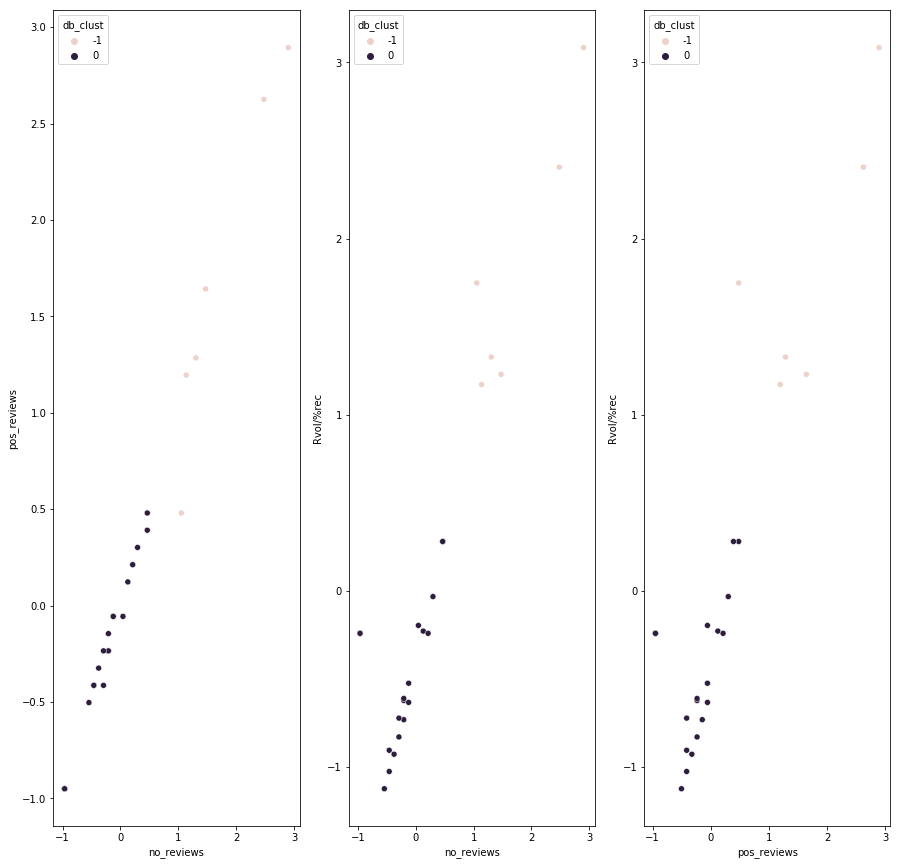

In [28]:
desktops['db_clust'] = pd.Series(db_clust, index=desktops.index)
f, axes = plt.subplots(1,3, figsize=(15,15))
sns.scatterplot(x=desktops['no_reviews'], y=desktops['pos_reviews'], hue=desktops['db_clust'],ax=axes[0])
sns.scatterplot(x=desktops['no_reviews'], y=desktops['Rvol/%rec'],hue=desktops['db_clust'], ax=axes[1])
sns.scatterplot(x=desktops['pos_reviews'], y=desktops['Rvol/%rec'],hue=desktops['db_clust'], ax=axes[2])

## tablets

In [29]:

dbscan_model = DBSCAN(eps=1.2, min_samples=(len(tablets))/5)
db_clust = dbscan_model.fit_predict(tablets[['no_reviews']])
tablets['db_clust'] = pd.Series(db_clust, index=tablets.index)
get_eval_scores(tablets['y_true'], tablets['db_clust'])

(1.0, 0.18181818181818182, 0.3076923076923077)

In [30]:
dbscan_model = DBSCAN(eps=0.95, min_samples=(len(tablets))/5)
db_clust = dbscan_model.fit_predict(tablets[['no_reviews','Rvol/%rec']])
tablets['db_clust'] = pd.Series(db_clust, index=tablets.index)
get_eval_scores(tablets['y_true'], tablets['db_clust'])

(0.6363636363636364, 0.6363636363636364, 0.6363636363636364)

In [31]:
print(tablets.loc[tablets.db_clust==-1]['TOTAL_SALES'].mean())
print(tablets.loc[tablets.db_clust==-0]['TOTAL_SALES'].mean())

1.2792104284931283
-0.19275773580033434


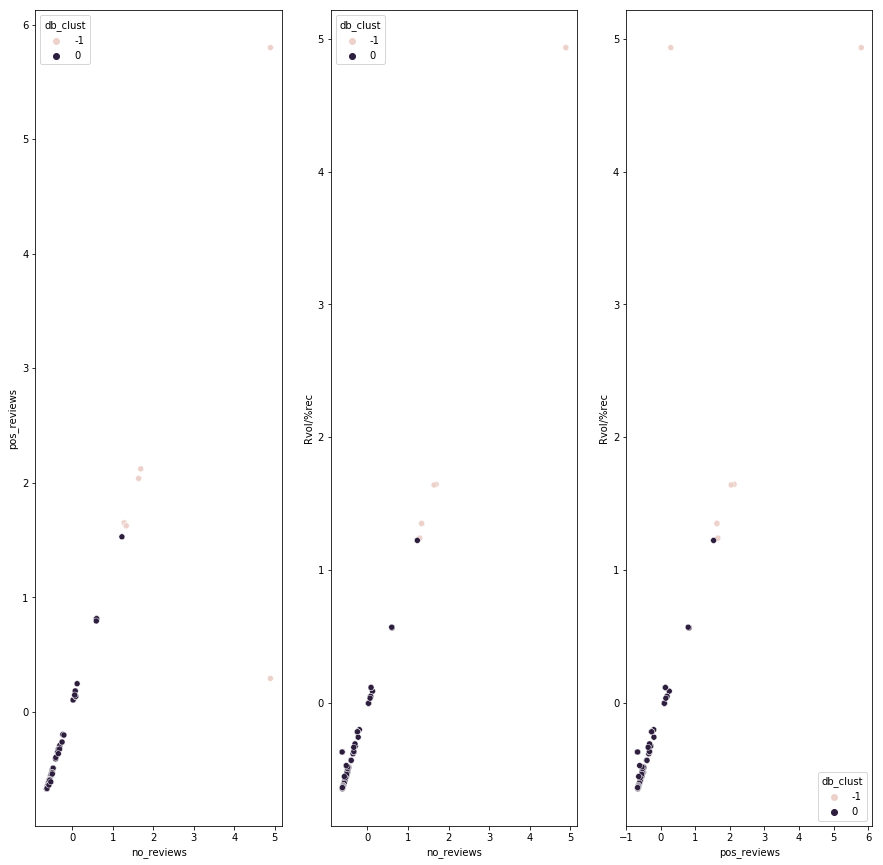

In [32]:
tablets['db_clust'] = pd.Series(db_clust, index=tablets.index)
f, axes = plt.subplots(1,3, figsize=(15,15))
sns.scatterplot(x=tablets['no_reviews'], y=tablets['pos_reviews'], hue=tablets['db_clust'],ax=axes[0])
sns.scatterplot(x=tablets['no_reviews'], y=tablets['Rvol/%rec'],hue=tablets['db_clust'], ax=axes[1])
sns.scatterplot(x=tablets['pos_reviews'], y=tablets['Rvol/%rec'],hue=tablets['db_clust'], ax=axes[2])